# 🔬 Bitcoin Market Sentiment & Hyperliquid Trader Performance Analysis

---

## Executive Summary
This analysis explores the relationship between **Bitcoin market sentiment** (Fear & Greed Index) and **trader performance** on Hyperliquid, a decentralized perpetual futures exchange. We aim to:

1. **Understand** how trader behavior and profitability change across different sentiment regimes
2. **Identify** patterns that successful traders exploit
3. **Generate** actionable insights for smarter trading strategies

---

## 1. Setup & Data Loading

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11
sns.set_palette('viridis')

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.2f}'.format)

print("✅ Libraries loaded successfully!")

✅ Libraries loaded successfully!


In [2]:
# Load datasets
fear_greed_df = pd.read_csv('fear_greed_index.csv')
trades_df = pd.read_csv('historical_data.csv')

print(f"📊 Fear/Greed Index: {len(fear_greed_df):,} rows")
print(f"📊 Trading History: {len(trades_df):,} rows")
print(f"\n--- Fear/Greed Sample ---")
display(fear_greed_df.head())
print(f"\n--- Trading Data Sample ---")
display(trades_df.head())

📊 Fear/Greed Index: 2,644 rows
📊 Trading History: 211,224 rows

--- Fear/Greed Sample ---


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05



--- Trading Data Sample ---


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.98,986.87,7872.16,BUY,02-12-2024 22:50,0.00,Buy,0.00,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.35,895000000000000.00,1730000000000.00
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.98,16.00,127.68,BUY,02-12-2024 22:50,986.52,Buy,0.00,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.01,443000000000000.00,1730000000000.00
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.99,144.09,1150.63,BUY,02-12-2024 22:50,1002.52,Buy,0.00,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.05,660000000000000.00,1730000000000.00
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.99,142.98,1142.04,BUY,02-12-2024 22:50,1146.56,Buy,0.00,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.05,1080000000000000.00,1730000000000.00
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.99,8.73,69.75,BUY,02-12-2024 22:50,1289.49,Buy,0.00,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.00,1050000000000000.00,1730000000000.00


In [3]:
# Data type inspection
print("=" * 60)
print("FEAR/GREED INDEX DATA TYPES")
print("=" * 60)
print(fear_greed_df.dtypes)
print(f"\nDate range: {fear_greed_df['date'].min()} to {fear_greed_df['date'].max()}")

print("\n" + "=" * 60)
print("TRADING DATA TYPES")
print("=" * 60)
print(trades_df.dtypes)

FEAR/GREED INDEX DATA TYPES
timestamp          int64
value              int64
classification    object
date              object
dtype: object

Date range: 2018-02-01 to 2025-05-02

TRADING DATA TYPES
Account              object
Coin                 object
Execution Price     float64
Size Tokens         float64
Size USD            float64
Side                 object
Timestamp IST        object
Start Position      float64
Direction            object
Closed PnL          float64
Transaction Hash     object
Order ID              int64
Crossed                bool
Fee                 float64
Trade ID            float64
Timestamp           float64
dtype: object


## 2. Data Preprocessing

In [4]:
# Clean Fear/Greed data
fear_greed_df['date'] = pd.to_datetime(fear_greed_df['date'])
fear_greed_df = fear_greed_df.sort_values('date').reset_index(drop=True)

# Define sentiment order for proper categorical ordering
sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
fear_greed_df['classification'] = pd.Categorical(
    fear_greed_df['classification'], 
    categories=sentiment_order, 
    ordered=True
)

print(f"✅ Fear/Greed data cleaned")
print(f"   Date range: {fear_greed_df['date'].min().date()} to {fear_greed_df['date'].max().date()}")
print(f"\n   Sentiment Distribution:")
print(fear_greed_df['classification'].value_counts().sort_index())

✅ Fear/Greed data cleaned
   Date range: 2018-02-01 to 2025-05-02

   Sentiment Distribution:
classification
Extreme Fear     508
Fear             781
Neutral          396
Greed            633
Extreme Greed    326
Name: count, dtype: int64


In [5]:
# Clean Trading data
# Parse the timestamp column (handling 'Timestamp IST' format: DD-MM-YYYY HH:MM)
trades_df['Timestamp IST'] = pd.to_datetime(trades_df['Timestamp IST'], format='%d-%m-%Y %H:%M', errors='coerce')
trades_df['trade_date'] = trades_df['Timestamp IST'].dt.date
trades_df['trade_date'] = pd.to_datetime(trades_df['trade_date'])

# Convert numeric columns
numeric_cols = ['Execution Price', 'Size Tokens', 'Size USD', 'Closed PnL', 'Fee']
for col in numeric_cols:
    trades_df[col] = pd.to_numeric(trades_df[col], errors='coerce')

# Clean account addresses (lowercase for consistency)
trades_df['Account'] = trades_df['Account'].str.lower()

# Identify trade direction from 'Direction' column
trades_df['is_long'] = trades_df['Direction'].str.contains('Buy|Long', case=False, na=False)
trades_df['is_win'] = trades_df['Closed PnL'] > 0

print(f"✅ Trading data cleaned")
print(f"   Date range: {trades_df['trade_date'].min().date()} to {trades_df['trade_date'].max().date()}")
print(f"   Unique traders: {trades_df['Account'].nunique():,}")
print(f"   Unique coins: {trades_df['Coin'].nunique():,}")
print(f"   Total volume: ${trades_df['Size USD'].sum():,.0f}")

✅ Trading data cleaned
   Date range: 2023-05-01 to 2025-05-01
   Unique traders: 32
   Unique coins: 246
   Total volume: $1,191,187,442


In [6]:
# Merge datasets on date
merged_df = trades_df.merge(
    fear_greed_df[['date', 'value', 'classification']], 
    left_on='trade_date', 
    right_on='date',
    how='left'
)

# Rename for clarity
merged_df = merged_df.rename(columns={
    'value': 'sentiment_value',
    'classification': 'sentiment_class'
})

# Drop rows without sentiment data (dates outside Fear/Greed coverage)
print(f"Trades before merge: {len(trades_df):,}")
print(f"Trades with sentiment data: {merged_df['sentiment_value'].notna().sum():,}")
print(f"Trades missing sentiment: {merged_df['sentiment_value'].isna().sum():,}")

merged_df = merged_df.dropna(subset=['sentiment_value'])
print(f"\n✅ Final merged dataset: {len(merged_df):,} trades")

Trades before merge: 211,224
Trades with sentiment data: 211,218
Trades missing sentiment: 6

✅ Final merged dataset: 211,218 trades


---

## 3. Fear & Greed Index Analysis

In [7]:
# Filter sentiment data to trading period only
trading_start = trades_df['trade_date'].min()
trading_end = trades_df['trade_date'].max()

trading_period_sentiment = fear_greed_df[
    (fear_greed_df['date'] >= trading_start) & 
    (fear_greed_df['date'] <= trading_end)
].copy()

print(f"📅 Trading Period: {trading_start.date()} to {trading_end.date()}")
print(f"\n📊 Sentiment Statistics during trading period:")
print(trading_period_sentiment['value'].describe())

📅 Trading Period: 2023-05-01 to 2025-05-01

📊 Sentiment Statistics during trading period:
count   731.00
mean     58.19
std      16.68
min      10.00
25%      47.00
50%      60.00
75%      72.00
max      94.00
Name: value, dtype: float64


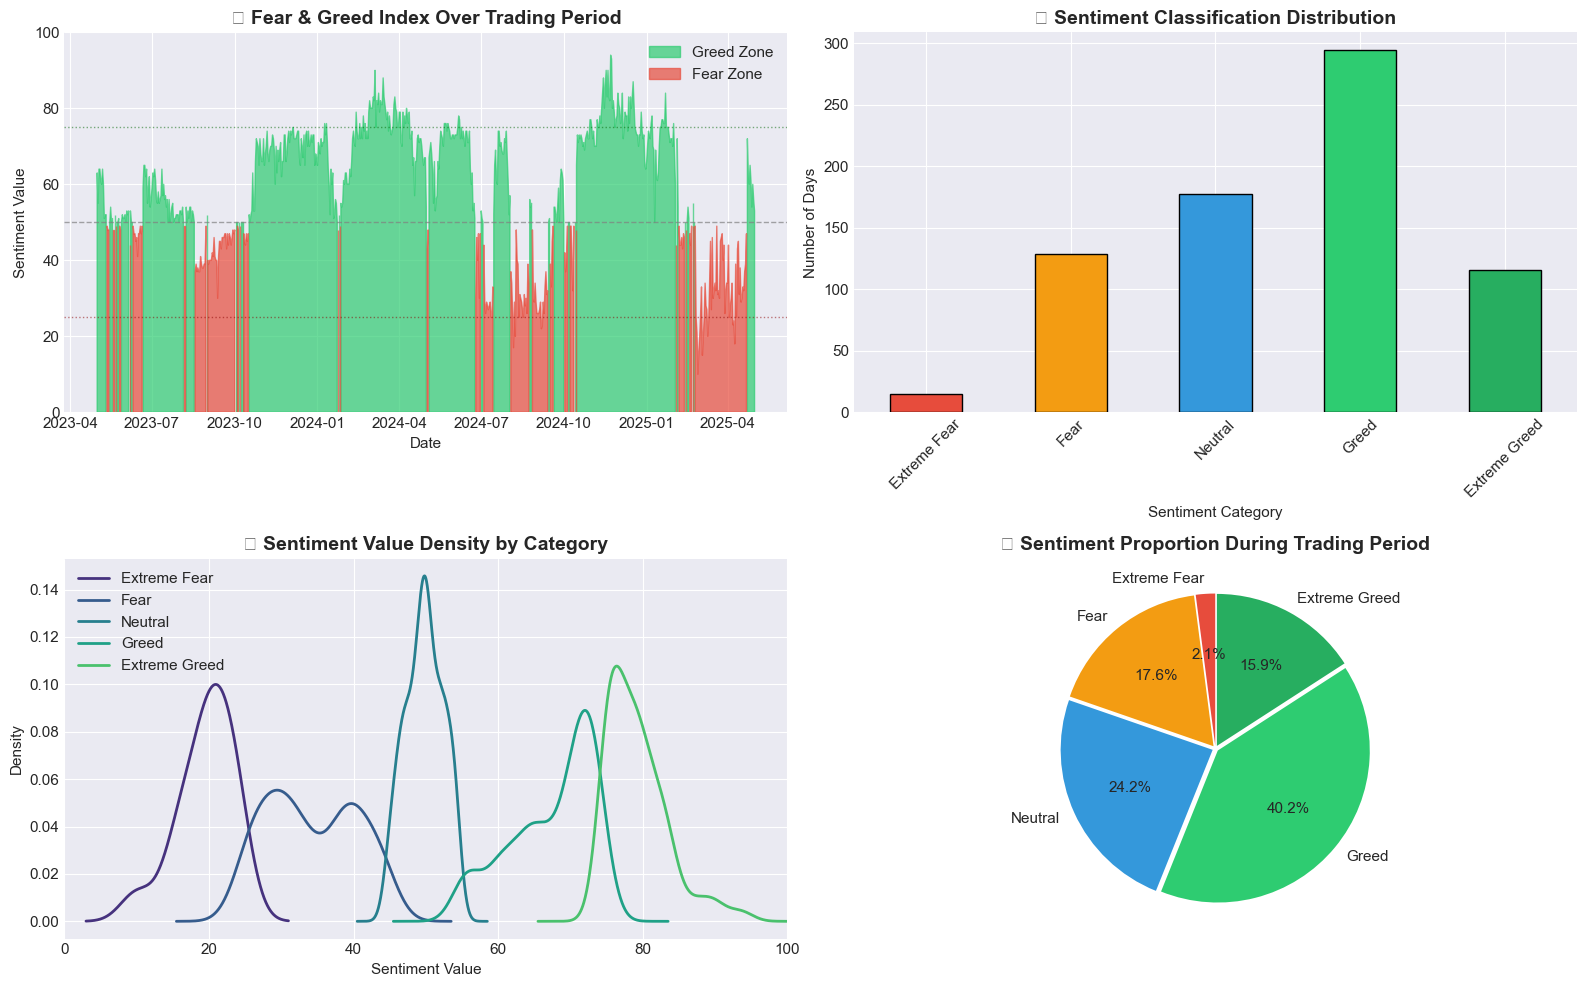

💾 Saved: sentiment_analysis.png


In [8]:
# Sentiment time series visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Time series of sentiment values
ax1 = axes[0, 0]
ax1.fill_between(trading_period_sentiment['date'], trading_period_sentiment['value'], 
                 where=(trading_period_sentiment['value'] >= 50), color='#2ecc71', alpha=0.7, label='Greed Zone')
ax1.fill_between(trading_period_sentiment['date'], trading_period_sentiment['value'], 
                 where=(trading_period_sentiment['value'] < 50), color='#e74c3c', alpha=0.7, label='Fear Zone')
ax1.axhline(y=50, color='gray', linestyle='--', linewidth=1, alpha=0.7)
ax1.axhline(y=25, color='darkred', linestyle=':', linewidth=1, alpha=0.5)
ax1.axhline(y=75, color='darkgreen', linestyle=':', linewidth=1, alpha=0.5)
ax1.set_title('📈 Fear & Greed Index Over Trading Period', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment Value')
ax1.legend(loc='upper right')
ax1.set_ylim(0, 100)

# 2. Distribution histogram
ax2 = axes[0, 1]
colors = ['#e74c3c', '#f39c12', '#3498db', '#2ecc71', '#27ae60']
trading_period_sentiment['classification'].value_counts().sort_index().plot(
    kind='bar', ax=ax2, color=colors, edgecolor='black'
)
ax2.set_title('📊 Sentiment Classification Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Sentiment Category')
ax2.set_ylabel('Number of Days')
ax2.tick_params(axis='x', rotation=45)

# 3. Value distribution kde
ax3 = axes[1, 0]
for sentiment in sentiment_order:
    subset = trading_period_sentiment[trading_period_sentiment['classification'] == sentiment]
    if len(subset) > 0:
        subset['value'].plot(kind='kde', ax=ax3, label=sentiment, linewidth=2)
ax3.set_title('📉 Sentiment Value Density by Category', fontsize=14, fontweight='bold')
ax3.set_xlabel('Sentiment Value')
ax3.set_ylabel('Density')
ax3.legend()
ax3.set_xlim(0, 100)

# 4. Pie chart of sentiment distribution
ax4 = axes[1, 1]
sentiment_counts = trading_period_sentiment['classification'].value_counts().sort_index()
ax4.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', 
        colors=colors, startangle=90, explode=[0.02]*len(sentiment_counts))
ax4.set_title('🥧 Sentiment Proportion During Trading Period', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('sentiment_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("💾 Saved: sentiment_analysis.png")

---

## 4. Trader Performance Deep Dive

In [9]:
# Aggregate trader-level metrics
trader_stats = merged_df.groupby('Account').agg({
    'Closed PnL': ['sum', 'mean', 'std', 'count'],
    'Size USD': ['sum', 'mean'],
    'is_win': 'mean',
    'Coin': 'nunique',
    'trade_date': ['min', 'max']
}).round(2)

# Flatten column names
trader_stats.columns = [
    'total_pnl', 'avg_pnl', 'pnl_std', 'trade_count',
    'total_volume', 'avg_trade_size',
    'win_rate', 'unique_coins',
    'first_trade', 'last_trade'
]

# Calculate additional metrics
trader_stats['trading_days'] = (trader_stats['last_trade'] - trader_stats['first_trade']).dt.days + 1
trader_stats['trades_per_day'] = trader_stats['trade_count'] / trader_stats['trading_days'].clip(lower=1)
trader_stats['sharpe_ratio'] = trader_stats['avg_pnl'] / trader_stats['pnl_std'].replace(0, np.nan)

# Classify traders by performance
trader_stats['performance_tier'] = pd.cut(
    trader_stats['total_pnl'],
    bins=[-np.inf, -10000, -1000, 0, 1000, 10000, np.inf],
    labels=['Heavy Loss', 'Moderate Loss', 'Break Even-', 'Break Even+', 'Moderate Profit', 'Heavy Profit']
)

trader_stats = trader_stats.reset_index()

print(f"📊 Trader Statistics Summary")
print(f"   Total Traders: {len(trader_stats):,}")
print(f"   Profitable Traders: {(trader_stats['total_pnl'] > 0).sum():,} ({(trader_stats['total_pnl'] > 0).mean():.1%})")
print(f"   Total PnL (All Traders): ${trader_stats['total_pnl'].sum():,.2f}")
print(f"\n📈 Top 10 Performers:")
display(trader_stats.nlargest(10, 'total_pnl')[['Account', 'total_pnl', 'win_rate', 'trade_count', 'avg_trade_size']])

📊 Trader Statistics Summary
   Total Traders: 32
   Profitable Traders: 29 (90.6%)
   Total PnL (All Traders): $10,254,486.96

📈 Top 10 Performers:


,Account,total_pnl,win_rate,trade_count,avg_trade_size
27,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,2143382.60,0.34,14733,3837.89
0,0x083384f897ee0f19899168e3b1bec365f52a9012,1600229.82,0.36,3818,16159.58
29,0xbaaaf6571ab7d571043ff1e313a9609a10637864,940163.81,0.47,21192,3210.47
13,0x513b8629fe877bb581bf244e326a047b249c4ff1,840422.56,0.40,12236,34396.58
31,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,836080.55,0.43,40184,1844.21
11,0x4acb90e786d897ecffb614dc822eb231b4ffb9f4,677747.05,0.49,4356,9084.70
15,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,429355.57,0.35,1590,7216.67
9,0x430f09841d65beb3f27765503d0f850b8bce7713,416541.87,0.48,1237,2397.82
17,0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4,379095.41,0.81,9893,2600.78
16,0x72c6a4624e1dffa724e6d00d64ceae698af892a0,360539.51,0.30,1424,2080.39


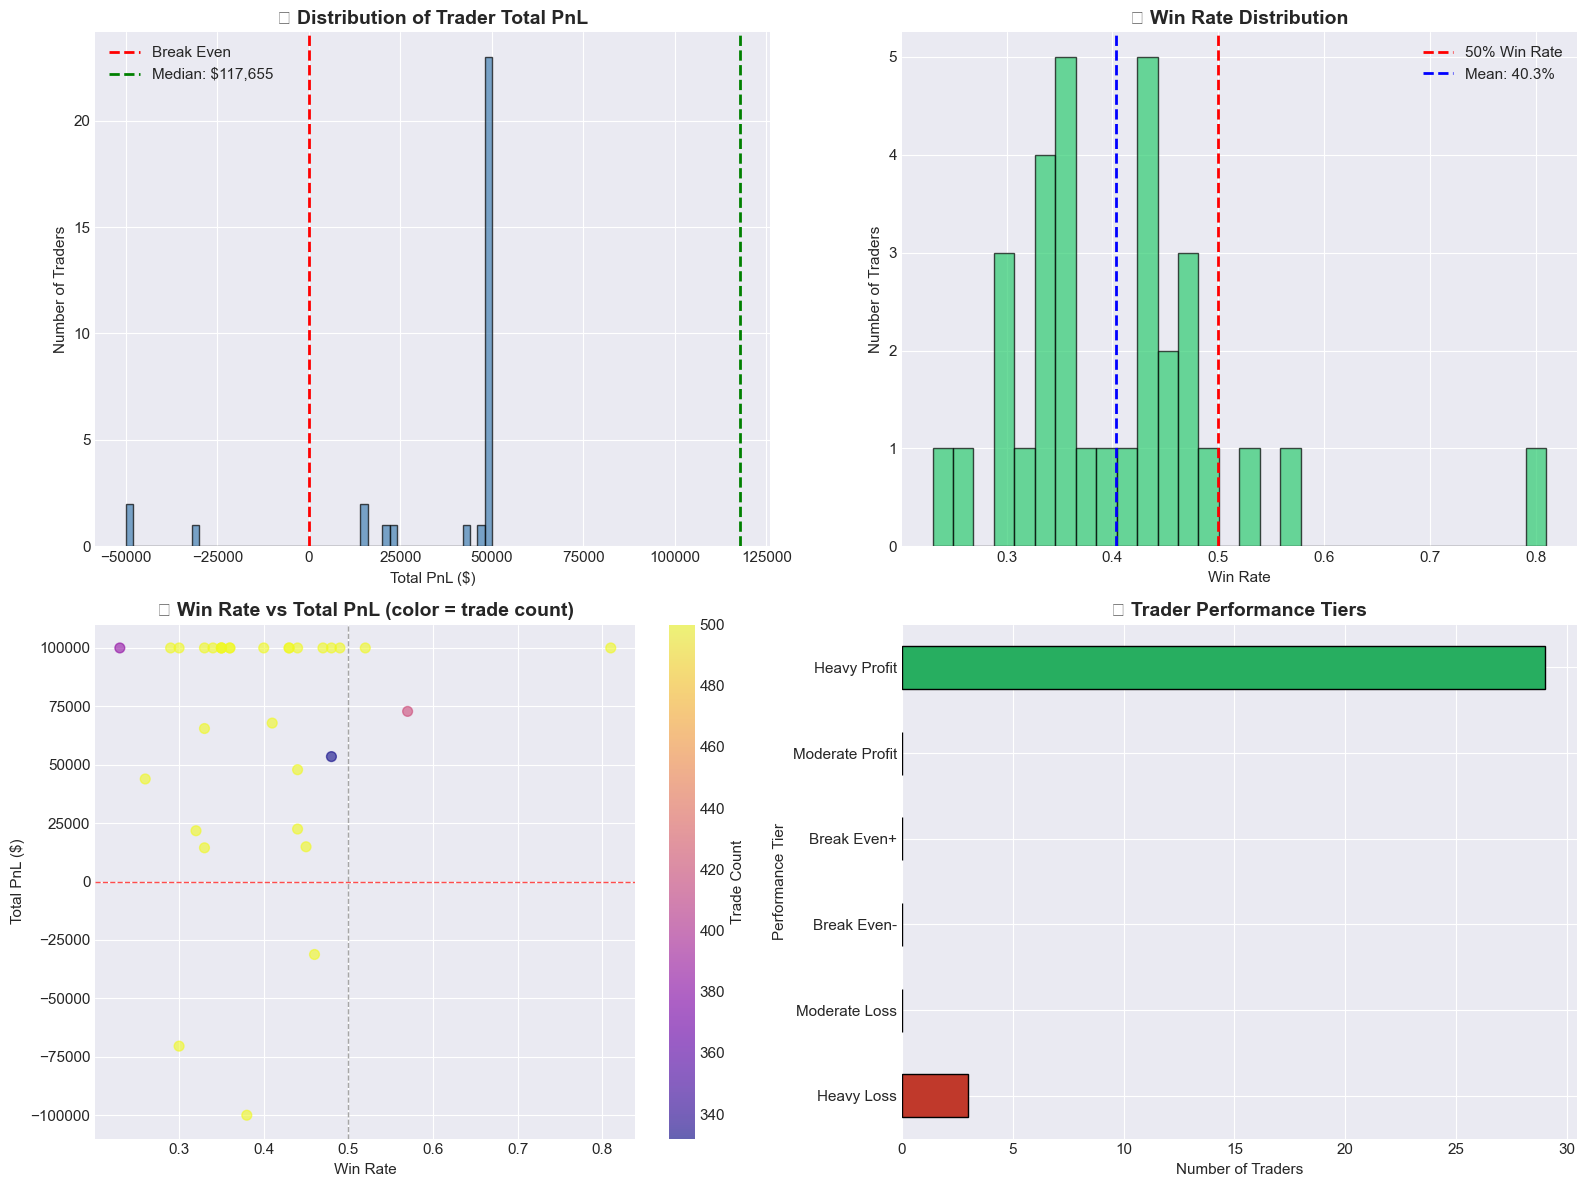

💾 Saved: trader_performance.png


In [10]:
# Trader performance visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. PnL Distribution
ax1 = axes[0, 0]
trader_stats['total_pnl'].clip(-50000, 50000).hist(bins=50, ax=ax1, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Break Even')
ax1.axvline(x=trader_stats['total_pnl'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: ${trader_stats["total_pnl"].median():,.0f}')
ax1.set_title('💰 Distribution of Trader Total PnL', fontsize=14, fontweight='bold')
ax1.set_xlabel('Total PnL ($)')
ax1.set_ylabel('Number of Traders')
ax1.legend()

# 2. Win Rate Distribution
ax2 = axes[0, 1]
trader_stats['win_rate'].hist(bins=30, ax=ax2, color='#2ecc71', edgecolor='black', alpha=0.7)
ax2.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='50% Win Rate')
ax2.axvline(x=trader_stats['win_rate'].mean(), color='blue', linestyle='--', linewidth=2, 
            label=f'Mean: {trader_stats["win_rate"].mean():.1%}')
ax2.set_title('🎯 Win Rate Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Win Rate')
ax2.set_ylabel('Number of Traders')
ax2.legend()

# 3. Win Rate vs PnL Scatter
ax3 = axes[1, 0]
scatter = ax3.scatter(
    trader_stats['win_rate'], 
    trader_stats['total_pnl'].clip(-100000, 100000),
    c=trader_stats['trade_count'].clip(0, 500),
    cmap='plasma',
    alpha=0.6,
    s=50
)
ax3.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.7)
ax3.axvline(x=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.7)
ax3.set_title('🔍 Win Rate vs Total PnL (color = trade count)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Win Rate')
ax3.set_ylabel('Total PnL ($)')
plt.colorbar(scatter, ax=ax3, label='Trade Count')

# 4. Performance Tier Distribution
ax4 = axes[1, 1]
tier_colors = ['#c0392b', '#e74c3c', '#f39c12', '#f1c40f', '#2ecc71', '#27ae60']
trader_stats['performance_tier'].value_counts().sort_index().plot(
    kind='barh', ax=ax4, color=tier_colors, edgecolor='black'
)
ax4.set_title('📊 Trader Performance Tiers', fontsize=14, fontweight='bold')
ax4.set_xlabel('Number of Traders')
ax4.set_ylabel('Performance Tier')

plt.tight_layout()
plt.savefig('trader_performance.png', dpi=150, bbox_inches='tight')
plt.show()

print("💾 Saved: trader_performance.png")

---

## 5. ⭐ CORE ANALYSIS: Sentiment vs Trader Performance

In [11]:
# Aggregate performance by sentiment classification
sentiment_performance = merged_df.groupby('sentiment_class').agg({
    'Closed PnL': ['sum', 'mean', 'median', 'std', 'count'],
    'Size USD': ['sum', 'mean'],
    'is_win': ['mean', 'sum'],
    'Account': 'nunique'
}).round(4)

sentiment_performance.columns = [
    'total_pnl', 'avg_pnl', 'median_pnl', 'pnl_std', 'trade_count',
    'total_volume', 'avg_trade_size',
    'win_rate', 'winning_trades',
    'active_traders'
]

sentiment_performance['pnl_per_dollar'] = sentiment_performance['total_pnl'] / sentiment_performance['total_volume']
sentiment_performance['avg_volume_per_trade'] = sentiment_performance['total_volume'] / sentiment_performance['trade_count']

print("="*80)
print("🎯 PERFORMANCE BY MARKET SENTIMENT")
print("="*80)
display(sentiment_performance)

🎯 PERFORMANCE BY MARKET SENTIMENT


,total_pnl,avg_pnl,median_pnl,pnl_std,trade_count,total_volume,avg_trade_size,win_rate,winning_trades,active_traders,pnl_per_dollar,avg_volume_per_trade
sentiment_class,,,,,,,,,,,,
Extreme Fear,739110.25,34.54,0.00,1136.06,21400,114484261.44,5349.73,0.37,7931,32,0.01,5349.73
Fear,3357155.44,54.29,0.00,935.36,61837,483324789.79,7816.11,0.42,26019,32,0.01,7816.11
Neutral,1292920.68,34.31,0.00,517.12,37686,180242063.08,4782.73,0.40,14961,31,0.01,4782.73
Greed,2150129.27,42.74,0.00,1116.03,50303,288582494.72,5736.88,0.38,19358,31,0.01,5736.88
Extreme Greed,2715171.31,67.89,0.00,766.83,39992,124465164.57,3112.25,0.46,18594,30,0.02,3112.25


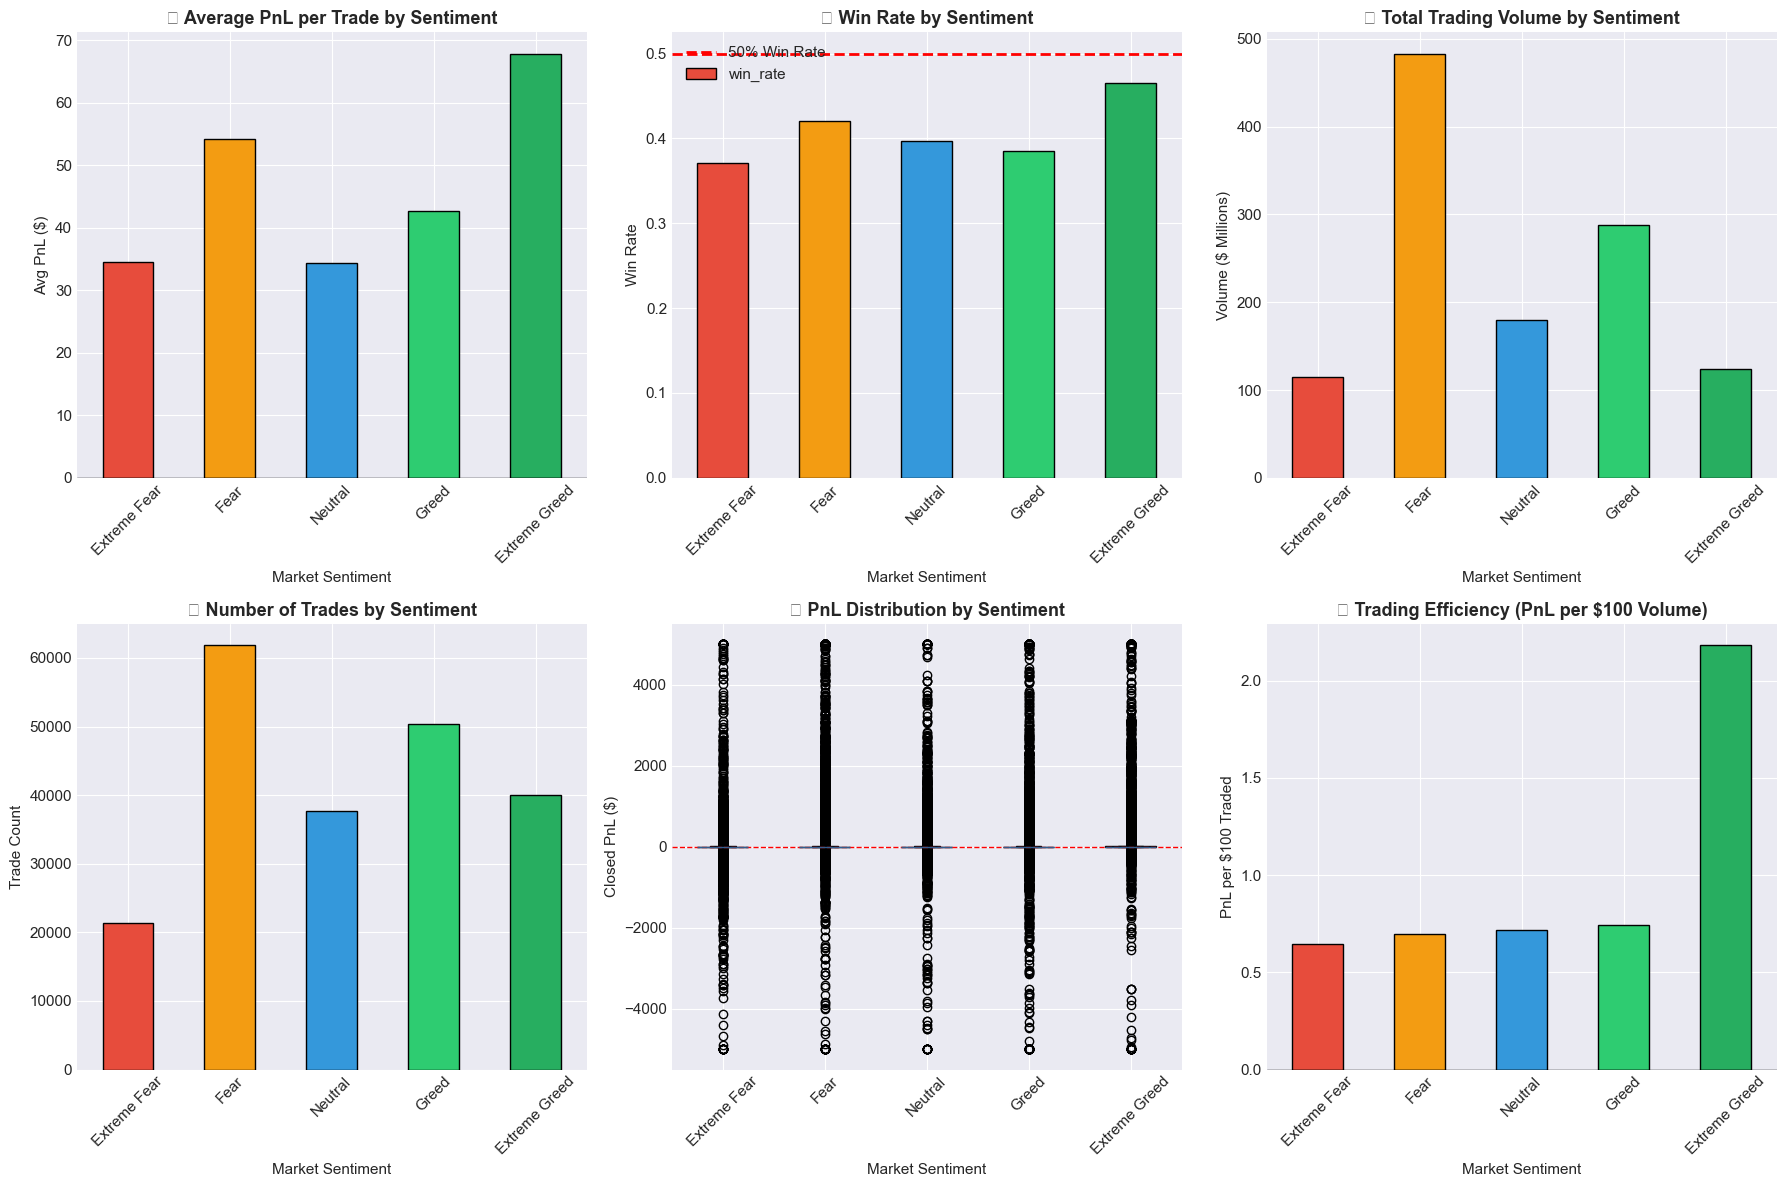

💾 Saved: sentiment_performance_analysis.png


In [12]:
# Create comprehensive sentiment-performance visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

sentiment_colors = ['#e74c3c', '#f39c12', '#3498db', '#2ecc71', '#27ae60']

# 1. Average PnL by Sentiment
ax1 = axes[0, 0]
sentiment_performance['avg_pnl'].plot(kind='bar', ax=ax1, color=sentiment_colors, edgecolor='black')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax1.set_title('💵 Average PnL per Trade by Sentiment', fontsize=13, fontweight='bold')
ax1.set_xlabel('Market Sentiment')
ax1.set_ylabel('Avg PnL ($)')
ax1.tick_params(axis='x', rotation=45)

# 2. Win Rate by Sentiment
ax2 = axes[0, 1]
sentiment_performance['win_rate'].plot(kind='bar', ax=ax2, color=sentiment_colors, edgecolor='black')
ax2.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='50% Win Rate')
ax2.set_title('🎯 Win Rate by Sentiment', fontsize=13, fontweight='bold')
ax2.set_xlabel('Market Sentiment')
ax2.set_ylabel('Win Rate')
ax2.tick_params(axis='x', rotation=45)
ax2.legend()

# 3. Trading Volume by Sentiment
ax3 = axes[0, 2]
(sentiment_performance['total_volume'] / 1e6).plot(kind='bar', ax=ax3, color=sentiment_colors, edgecolor='black')
ax3.set_title('📊 Total Trading Volume by Sentiment', fontsize=13, fontweight='bold')
ax3.set_xlabel('Market Sentiment')
ax3.set_ylabel('Volume ($ Millions)')
ax3.tick_params(axis='x', rotation=45)

# 4. Trade Count by Sentiment
ax4 = axes[1, 0]
sentiment_performance['trade_count'].plot(kind='bar', ax=ax4, color=sentiment_colors, edgecolor='black')
ax4.set_title('📈 Number of Trades by Sentiment', fontsize=13, fontweight='bold')
ax4.set_xlabel('Market Sentiment')
ax4.set_ylabel('Trade Count')
ax4.tick_params(axis='x', rotation=45)

# 5. Box plot of PnL by Sentiment
ax5 = axes[1, 1]
pnl_by_sentiment = [merged_df[merged_df['sentiment_class'] == s]['Closed PnL'].clip(-5000, 5000).dropna() 
                    for s in sentiment_order]
bp = ax5.boxplot(pnl_by_sentiment, labels=sentiment_order, patch_artist=True)
for patch, color in zip(bp['boxes'], sentiment_colors):
    patch.set_facecolor(color)
ax5.axhline(y=0, color='red', linestyle='--', linewidth=1)
ax5.set_title('📦 PnL Distribution by Sentiment', fontsize=13, fontweight='bold')
ax5.set_xlabel('Market Sentiment')
ax5.set_ylabel('Closed PnL ($)')
ax5.tick_params(axis='x', rotation=45)

# 6. PnL per Dollar Volume (Efficiency)
ax6 = axes[1, 2]
(sentiment_performance['pnl_per_dollar'] * 100).plot(kind='bar', ax=ax6, color=sentiment_colors, edgecolor='black')
ax6.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax6.set_title('⚡ Trading Efficiency (PnL per $100 Volume)', fontsize=13, fontweight='bold')
ax6.set_xlabel('Market Sentiment')
ax6.set_ylabel('PnL per $100 Traded')
ax6.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('sentiment_performance_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("💾 Saved: sentiment_performance_analysis.png")

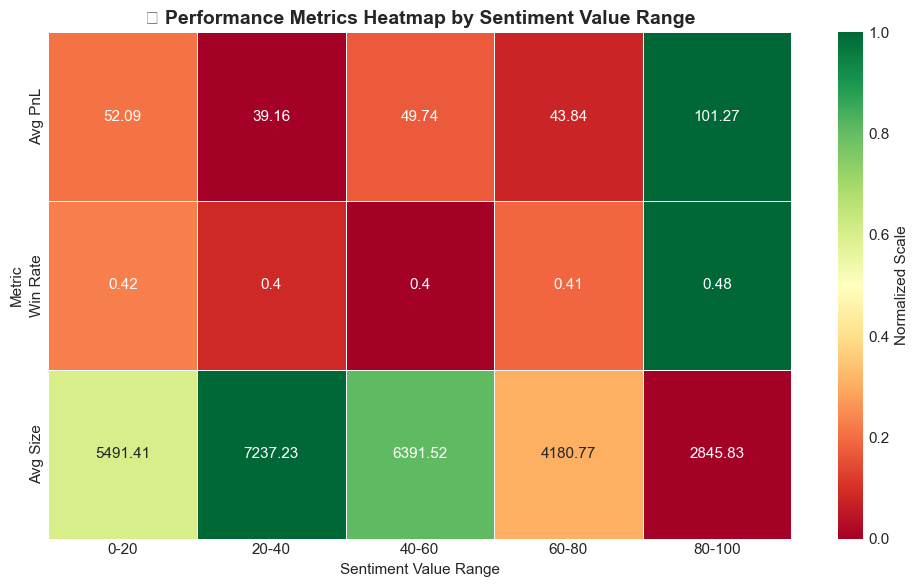

💾 Saved: sentiment_heatmap.png


In [13]:
# Heatmap: Sentiment Value Bins vs Performance Metrics
merged_df['sentiment_bin'] = pd.cut(
    merged_df['sentiment_value'], 
    bins=[0, 20, 40, 60, 80, 100],
    labels=['0-20', '20-40', '40-60', '60-80', '80-100']
)

# Group by sentiment bins
bin_performance = merged_df.groupby('sentiment_bin').agg({
    'Closed PnL': 'mean',
    'is_win': 'mean',
    'Size USD': 'mean'
}).round(4)

bin_performance.columns = ['Avg PnL', 'Win Rate', 'Avg Size']

# Normalize for heatmap
bin_normalized = (bin_performance - bin_performance.min()) / (bin_performance.max() - bin_performance.min())

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(bin_normalized.T, annot=bin_performance.T.round(2), fmt='', cmap='RdYlGn', 
            linewidths=0.5, ax=ax, cbar_kws={'label': 'Normalized Scale'})
ax.set_title('🔥 Performance Metrics Heatmap by Sentiment Value Range', fontsize=14, fontweight='bold')
ax.set_xlabel('Sentiment Value Range')
ax.set_ylabel('Metric')
plt.tight_layout()
plt.savefig('sentiment_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("💾 Saved: sentiment_heatmap.png")

---

## 6. 🔬 Advanced Pattern Discovery

In [14]:
# Daily aggregation for time-series analysis
daily_performance = merged_df.groupby('trade_date').agg({
    'Closed PnL': ['sum', 'mean', 'count'],
    'Size USD': 'sum',
    'is_win': 'mean',
    'sentiment_value': 'first',
    'sentiment_class': 'first'
}).round(4)

daily_performance.columns = ['daily_pnl', 'avg_pnl', 'trade_count', 'volume', 'win_rate', 'sentiment', 'sentiment_class']
daily_performance = daily_performance.reset_index()
daily_performance['cumulative_pnl'] = daily_performance['daily_pnl'].cumsum()

# Add rolling metrics
daily_performance['sentiment_7d_ma'] = daily_performance['sentiment'].rolling(7).mean()
daily_performance['pnl_7d_ma'] = daily_performance['daily_pnl'].rolling(7).mean()

print(f"📅 Daily performance data: {len(daily_performance)} trading days")
display(daily_performance.head(10))

📅 Daily performance data: 479 trading days


,trade_date,daily_pnl,avg_pnl,trade_count,volume,win_rate,sentiment,sentiment_class,cumulative_pnl,sentiment_7d_ma,pnl_7d_ma
0,2023-05-01,0.00,0.00,3,477.00,0.00,63.00,Greed,0.00,NaN,NaN
1,2023-12-05,0.00,0.00,9,50005.83,0.00,75.00,Extreme Greed,0.00,NaN,NaN
2,2023-12-14,-205.43,-18.68,11,113203.35,0.36,72.00,Greed,-205.43,NaN,NaN
3,2023-12-15,-24.63,-12.32,2,10609.95,0.00,70.00,Greed,-230.07,NaN,NaN
4,2023-12-16,0.00,0.00,3,15348.77,0.00,67.00,Greed,-230.07,NaN,NaN
5,2023-12-17,304.98,21.78,14,116278.02,0.50,73.00,Greed,74.92,NaN,NaN
6,2023-12-18,0.00,0.00,2,31164.18,0.00,65.00,Greed,74.92,69.29,10.70
7,2023-12-19,1000.54,66.70,15,91602.41,0.67,73.00,Greed,1075.45,70.71,153.64
8,2023-12-20,162.73,9.04,18,141636.79,0.44,74.00,Greed,1238.19,70.57,176.88
9,2023-12-21,537.21,10.96,49,125233.97,0.53,70.00,Greed,1775.40,70.29,282.98


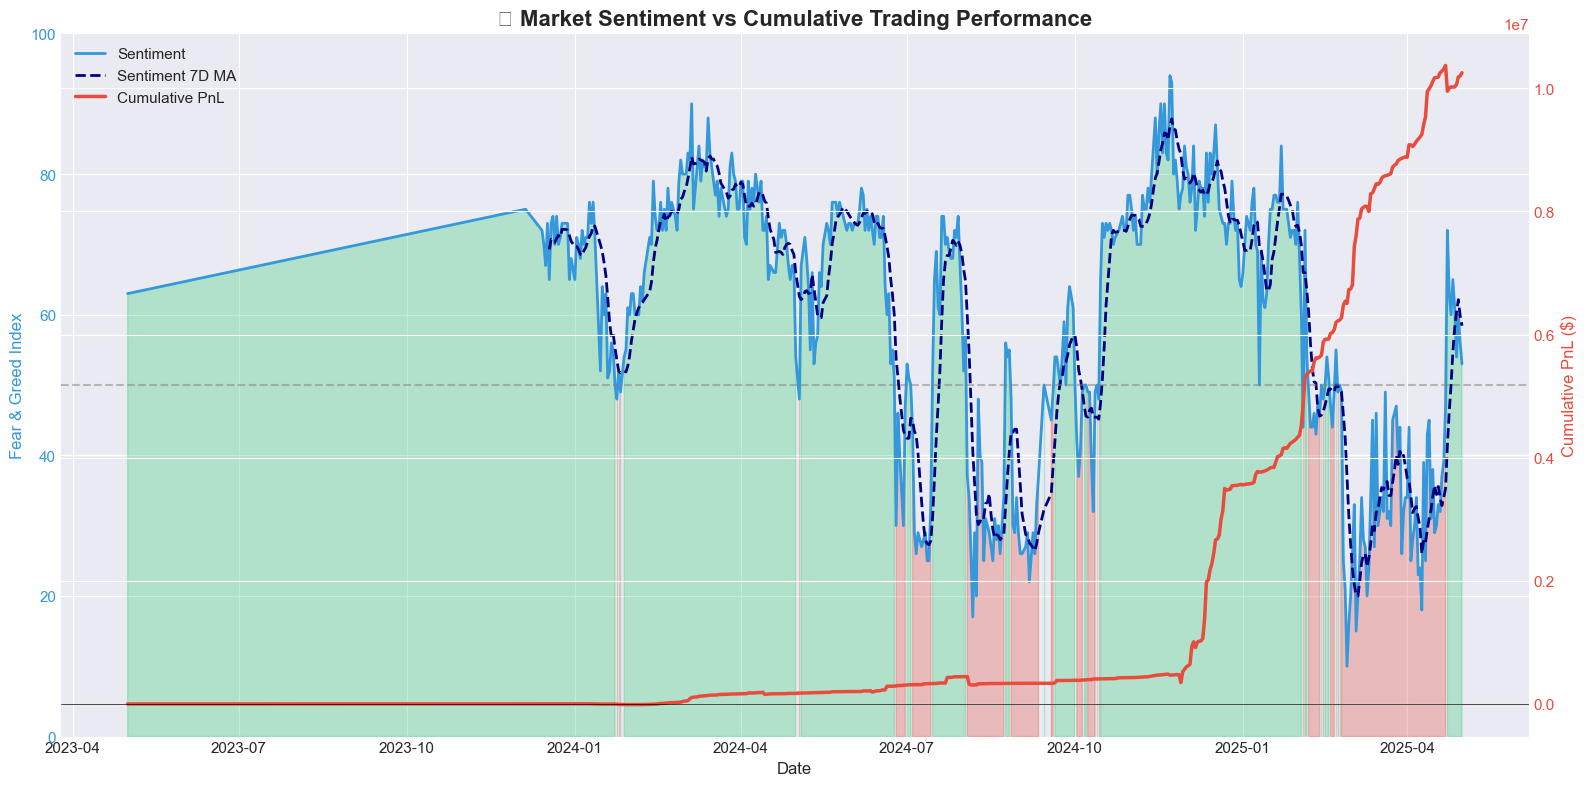

💾 Saved: sentiment_vs_pnl_timeseries.png


In [15]:
# Time-series overlay: Sentiment + Cumulative PnL
fig, ax1 = plt.subplots(figsize=(16, 8))

# Sentiment on primary y-axis
color1 = '#3498db'
ax1.fill_between(daily_performance['trade_date'], daily_performance['sentiment'], 
                 where=(daily_performance['sentiment'] >= 50), color='#2ecc71', alpha=0.3)
ax1.fill_between(daily_performance['trade_date'], daily_performance['sentiment'], 
                 where=(daily_performance['sentiment'] < 50), color='#e74c3c', alpha=0.3)
ax1.plot(daily_performance['trade_date'], daily_performance['sentiment'], color=color1, linewidth=2, label='Sentiment')
ax1.plot(daily_performance['trade_date'], daily_performance['sentiment_7d_ma'], color='navy', 
         linewidth=2, linestyle='--', label='Sentiment 7D MA')
ax1.axhline(y=50, color='gray', linestyle='--', alpha=0.5)
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Fear & Greed Index', color=color1, fontsize=12)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_ylim(0, 100)

# Cumulative PnL on secondary y-axis
ax2 = ax1.twinx()
color2 = '#e74c3c'
ax2.plot(daily_performance['trade_date'], daily_performance['cumulative_pnl'], 
         color=color2, linewidth=2.5, label='Cumulative PnL')
ax2.set_ylabel('Cumulative PnL ($)', color=color2, fontsize=12)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=11)

plt.title('📈 Market Sentiment vs Cumulative Trading Performance', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('sentiment_vs_pnl_timeseries.png', dpi=150, bbox_inches='tight')
plt.show()

print("💾 Saved: sentiment_vs_pnl_timeseries.png")

In [16]:
# Lag Analysis: Does today's sentiment predict tomorrow's performance?
daily_performance['sentiment_lag1'] = daily_performance['sentiment'].shift(1)
daily_performance['sentiment_lag2'] = daily_performance['sentiment'].shift(2)
daily_performance['sentiment_lag3'] = daily_performance['sentiment'].shift(3)

# Calculate correlations
lag_correlations = {
    'Same Day': daily_performance['sentiment'].corr(daily_performance['daily_pnl']),
    '1 Day Lag': daily_performance['sentiment_lag1'].corr(daily_performance['daily_pnl']),
    '2 Day Lag': daily_performance['sentiment_lag2'].corr(daily_performance['daily_pnl']),
    '3 Day Lag': daily_performance['sentiment_lag3'].corr(daily_performance['daily_pnl'])
}

print("="*60)
print("🔮 LAG CORRELATION ANALYSIS")
print("  (Does sentiment predict future performance?)")
print("="*60)
for lag, corr in lag_correlations.items():
    direction = "📈" if corr > 0 else "📉"
    strength = "Strong" if abs(corr) > 0.3 else "Moderate" if abs(corr) > 0.1 else "Weak"
    print(f"   {lag}: {corr:.4f} {direction} ({strength})")

🔮 LAG CORRELATION ANALYSIS
  (Does sentiment predict future performance?)
   Same Day: -0.0826 📉 (Weak)
   1 Day Lag: -0.1078 📉 (Moderate)
   2 Day Lag: -0.0765 📉 (Weak)
   3 Day Lag: -0.0861 📉 (Weak)


In [17]:
# Extreme Sentiment Deep Dive
extreme_fear = merged_df[merged_df['sentiment_class'] == 'Extreme Fear']
extreme_greed = merged_df[merged_df['sentiment_class'] == 'Extreme Greed']

print("="*70)
print("🔥 EXTREME SENTIMENT ANALYSIS")
print("="*70)

print(f"\n😱 EXTREME FEAR (<25):")
if len(extreme_fear) > 0:
    print(f"   Trades: {len(extreme_fear):,}")
    print(f"   Total PnL: ${extreme_fear['Closed PnL'].sum():,.2f}")
    print(f"   Win Rate: {extreme_fear['is_win'].mean():.2%}")
    print(f"   Avg Trade Size: ${extreme_fear['Size USD'].mean():,.2f}")
else:
    print("   No trades during Extreme Fear periods")

print(f"\n🚀 EXTREME GREED (>75):")
if len(extreme_greed) > 0:
    print(f"   Trades: {len(extreme_greed):,}")
    print(f"   Total PnL: ${extreme_greed['Closed PnL'].sum():,.2f}")
    print(f"   Win Rate: {extreme_greed['is_win'].mean():.2%}")
    print(f"   Avg Trade Size: ${extreme_greed['Size USD'].mean():,.2f}")
else:
    print("   No trades during Extreme Greed periods")

# Compare Long vs Short in extreme conditions
print(f"\n📊 LONG vs SHORT in Extreme Conditions:")
for condition, df in [('Extreme Fear', extreme_fear), ('Extreme Greed', extreme_greed)]:
    if len(df) > 0:
        longs = df[df['is_long'] == True]
        shorts = df[df['is_long'] == False]
        print(f"\n   {condition}:")
        print(f"      Longs:  {len(longs):,} trades, Avg PnL: ${longs['Closed PnL'].mean():.2f}")
        print(f"      Shorts: {len(shorts):,} trades, Avg PnL: ${shorts['Closed PnL'].mean():.2f}")

🔥 EXTREME SENTIMENT ANALYSIS

😱 EXTREME FEAR (<25):
   Trades: 21,400
   Total PnL: $739,110.25
   Win Rate: 37.06%
   Avg Trade Size: $5,349.73

🚀 EXTREME GREED (>75):
   Trades: 39,992
   Total PnL: $2,715,171.31
   Win Rate: 46.49%
   Avg Trade Size: $3,112.25

📊 LONG vs SHORT in Extreme Conditions:

   Extreme Fear:
      Longs:  14,064 trades, Avg PnL: $35.21
      Shorts: 7,336 trades, Avg PnL: $33.25

   Extreme Greed:
      Longs:  18,636 trades, Avg PnL: $23.89
      Shorts: 21,356 trades, Avg PnL: $106.29


🎯 TRADER SPECIALIZATION BY SENTIMENT

What sentiment do traders perform BEST in?
sentiment_class
Extreme Greed    15
Fear             10
Greed             5
Extreme Fear      1
Neutral           1
Name: count, dtype: int64


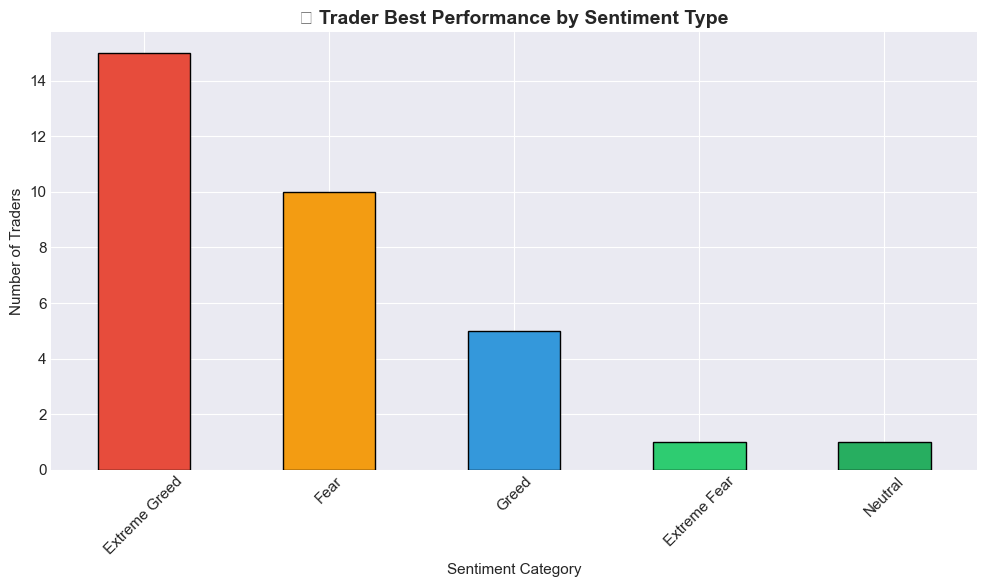


💾 Saved: trader_specialization.png


In [18]:
# Trader Segmentation: Who performs best in which sentiment?
trader_sentiment_perf = merged_df.groupby(['Account', 'sentiment_class']).agg({
    'Closed PnL': ['sum', 'mean'],
    'is_win': 'mean',
    'trade_date': 'count'
}).reset_index()

trader_sentiment_perf.columns = ['Account', 'sentiment_class', 'total_pnl', 'avg_pnl', 'win_rate', 'trade_count']

# Find best sentiment for each trader
best_sentiment_per_trader = trader_sentiment_perf.loc[
    trader_sentiment_perf.groupby('Account')['total_pnl'].idxmax()
][['Account', 'sentiment_class', 'total_pnl']]

print("="*60)
print("🎯 TRADER SPECIALIZATION BY SENTIMENT")
print("="*60)
print("\nWhat sentiment do traders perform BEST in?")
specialization_counts = best_sentiment_per_trader['sentiment_class'].value_counts()
print(specialization_counts)

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
specialization_counts.plot(kind='bar', ax=ax, color=sentiment_colors, edgecolor='black')
ax.set_title('🎯 Trader Best Performance by Sentiment Type', fontsize=14, fontweight='bold')
ax.set_xlabel('Sentiment Category')
ax.set_ylabel('Number of Traders')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig('trader_specialization.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💾 Saved: trader_specialization.png")

---

## 7. 📊 Asset-Level Analysis

In [19]:
# Asset performance analysis
asset_stats = merged_df.groupby('Coin').agg({
    'Closed PnL': ['sum', 'mean', 'count'],
    'Size USD': 'sum',
    'is_win': 'mean'
}).round(2)

asset_stats.columns = ['total_pnl', 'avg_pnl', 'trade_count', 'volume', 'win_rate']
asset_stats = asset_stats.reset_index()
asset_stats = asset_stats[asset_stats['trade_count'] >= 10]  # Filter to significant assets

print(f"📊 Assets with 10+ trades: {len(asset_stats)}")
print(f"\n🏆 Top 10 by Total PnL:")
display(asset_stats.nlargest(10, 'total_pnl'))

print(f"\n📉 Bottom 10 by Total PnL:")
display(asset_stats.nsmallest(10, 'total_pnl'))

📊 Assets with 10+ trades: 167

🏆 Top 10 by Total PnL:


,Coin,total_pnl,avg_pnl,trade_count,volume,win_rate
4,@107,2783912.92,92.82,29992,55760858.63,0.47
137,HYPE,1948484.60,28.65,68005,141990206.05,0.41
205,SOL,1639555.93,153.36,10691,125074752.06,0.39
120,ETH,1319978.84,118.30,11158,118280994.07,0.36
105,BTC,868044.73,33.30,26064,644232116.63,0.35
161,MELANIA,390351.07,88.16,4428,7040710.45,0.44
117,ENA,217329.50,219.52,990,1625400.50,0.31
210,SUI,199268.83,100.69,1979,7781167.59,0.42
240,ZRO,183777.78,148.33,1239,1213825.42,0.37
112,DOGE,147543.16,178.62,826,2452103.46,0.49



📉 Bottom 10 by Total PnL:


,Coin,total_pnl,avg_pnl,trade_count,volume,win_rate
217,TRUMP,-364824.91,-190.01,1920,7349346.94,0.35
122,FARTCOIN,-100687.21,-21.65,4650,8311390.40,0.33
79,ADA,-28113.46,-48.39,581,1094836.40,0.27
143,IO,-21893.91,-62.20,352,252981.67,0.16
181,PAXG,-18688.87,-14.77,1265,3047336.39,0.16
149,KAITO,-8735.14,-20.08,435,897912.98,0.24
200,S,-8644.85,-60.03,144,224183.08,0.26
188,POPCAT,-7922.18,-6.88,1152,803456.85,0.15
174,NIL,-3175.27,-14.05,226,481868.22,0.08
208,STRK,-1517.38,-31.61,48,83026.40,0.44


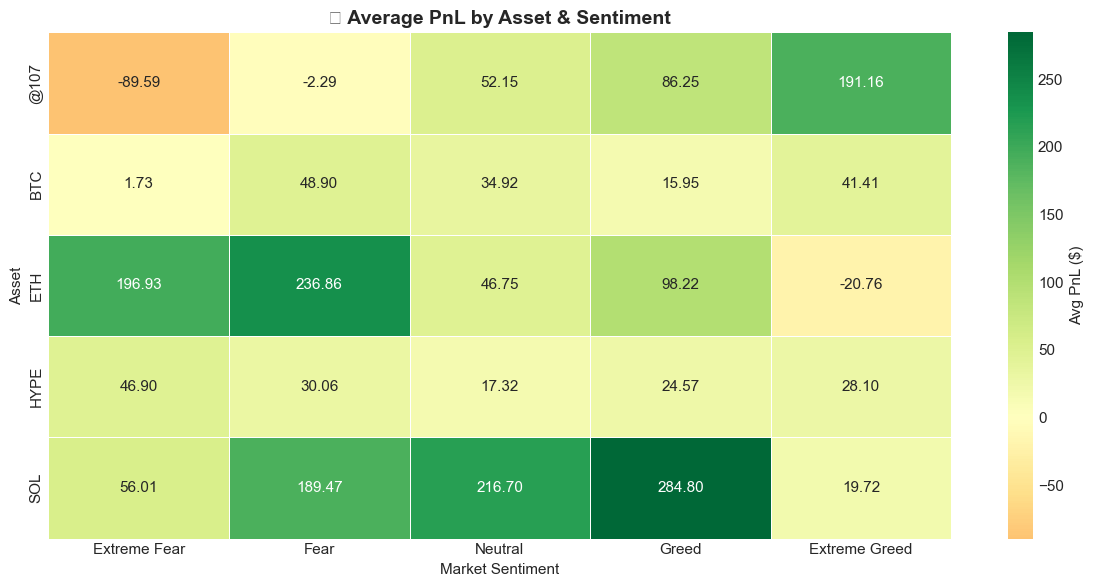

💾 Saved: asset_sentiment_heatmap.png


In [20]:
# Asset performance by sentiment
top_assets = asset_stats.nlargest(5, 'trade_count')['Coin'].tolist()

asset_sentiment_perf = merged_df[merged_df['Coin'].isin(top_assets)].groupby(['Coin', 'sentiment_class']).agg({
    'Closed PnL': 'mean',
    'is_win': 'mean'
}).round(4)

asset_sentiment_perf = asset_sentiment_perf.reset_index()
asset_sentiment_pivot = asset_sentiment_perf.pivot(index='Coin', columns='sentiment_class', values='Closed PnL')

# Heatmap
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(asset_sentiment_pivot, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            linewidths=0.5, ax=ax, cbar_kws={'label': 'Avg PnL ($)'})
ax.set_title('🔥 Average PnL by Asset & Sentiment', fontsize=14, fontweight='bold')
ax.set_xlabel('Market Sentiment')
ax.set_ylabel('Asset')
plt.tight_layout()
plt.savefig('asset_sentiment_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("💾 Saved: asset_sentiment_heatmap.png")

---

## 8. 💡 Key Insights & Trading Strategy Recommendations

In [21]:
# Generate summary statistics for key insights
print("="*80)
print("                    📊 ANALYSIS SUMMARY")
print("="*80)

print(f"\n📅 Analysis Period: {trading_start.date()} to {trading_end.date()}")
print(f"📈 Total Trades Analyzed: {len(merged_df):,}")
print(f"👥 Unique Traders: {merged_df['Account'].nunique():,}")
print(f"💰 Total Trading Volume: ${merged_df['Size USD'].sum():,.0f}")
print(f"💵 Net PnL (All Trades): ${merged_df['Closed PnL'].sum():,.2f}")

print(f"\n" + "="*80)
print("                    🎯 KEY FINDINGS")
print("="*80)

# Best and worst sentiment for trading
best_sentiment = sentiment_performance['avg_pnl'].idxmax()
worst_sentiment = sentiment_performance['avg_pnl'].idxmin()
highest_win_rate_sentiment = sentiment_performance['win_rate'].idxmax()
most_active_sentiment = sentiment_performance['trade_count'].idxmax()

print(f"\n1️⃣  BEST SENTIMENT FOR TRADING: {best_sentiment}")
print(f"    → Average PnL: ${sentiment_performance.loc[best_sentiment, 'avg_pnl']:.2f}")

print(f"\n2️⃣  WORST SENTIMENT FOR TRADING: {worst_sentiment}")
print(f"    → Average PnL: ${sentiment_performance.loc[worst_sentiment, 'avg_pnl']:.2f}")

print(f"\n3️⃣  HIGHEST WIN RATE: {highest_win_rate_sentiment}")
print(f"    → Win Rate: {sentiment_performance.loc[highest_win_rate_sentiment, 'win_rate']:.2%}")

print(f"\n4️⃣  MOST ACTIVE TRADING: {most_active_sentiment}")
print(f"    → Trades: {sentiment_performance.loc[most_active_sentiment, 'trade_count']:,.0f}")

print(f"\n5️⃣  PROFITABLE TRADERS: {(trader_stats['total_pnl'] > 0).mean():.1%}")
print(f"    → {(trader_stats['total_pnl'] > 0).sum()} out of {len(trader_stats)} traders made profit")

                    📊 ANALYSIS SUMMARY

📅 Analysis Period: 2023-05-01 to 2025-05-01
📈 Total Trades Analyzed: 211,218
👥 Unique Traders: 32
💰 Total Trading Volume: $1,191,098,774
💵 Net PnL (All Trades): $10,254,486.95

                    🎯 KEY FINDINGS

1️⃣  BEST SENTIMENT FOR TRADING: Extreme Greed
    → Average PnL: $67.89

2️⃣  WORST SENTIMENT FOR TRADING: Neutral
    → Average PnL: $34.31

3️⃣  HIGHEST WIN RATE: Extreme Greed
    → Win Rate: 46.49%

4️⃣  MOST ACTIVE TRADING: Fear
    → Trades: 61,837

5️⃣  PROFITABLE TRADERS: 90.6%
    → 29 out of 32 traders made profit


In [22]:
# Trading Strategy Recommendations
print("\n" + "="*80)
print("                    🚀 TRADING STRATEGY RECOMMENDATIONS")
print("="*80)

strategies = [
    {
        "name": "Contrarian Fear Trading",
        "description": "Consider buying during Extreme Fear periods when prices are depressed",
        "condition": "Fear/Greed Index < 25",
        "rationale": "Extreme fear often marks market bottoms; smart money accumulates here"
    },
    {
        "name": "Greed Zone Caution",
        "description": "Reduce position sizes during Extreme Greed to manage risk",
        "condition": "Fear/Greed Index > 75",
        "rationale": "Extreme greed often precedes corrections; protect profits"
    },
    {
        "name": "Neutral Zone Scalping",
        "description": "Optimal conditions for short-term trades with balanced risk/reward",
        "condition": "Fear/Greed Index 40-60",
        "rationale": "Market indecision creates opportunities for range-bound trading"
    },
    {
        "name": "Size Management",
        "description": "Scale positions inversely with sentiment extremity",
        "condition": "Dynamic sizing",
        "rationale": "Larger positions when sentiment normalizes; smaller during extremes"
    }
]

for i, strategy in enumerate(strategies, 1):
    print(f"\n📌 Strategy {i}: {strategy['name']}")
    print(f"   📝 {strategy['description']}")
    print(f"   ⚙️  Condition: {strategy['condition']}")
    print(f"   💡 Rationale: {strategy['rationale']}")


                    🚀 TRADING STRATEGY RECOMMENDATIONS

📌 Strategy 1: Contrarian Fear Trading
   📝 Consider buying during Extreme Fear periods when prices are depressed
   ⚙️  Condition: Fear/Greed Index < 25
   💡 Rationale: Extreme fear often marks market bottoms; smart money accumulates here

📌 Strategy 2: Greed Zone Caution
   📝 Reduce position sizes during Extreme Greed to manage risk
   ⚙️  Condition: Fear/Greed Index > 75
   💡 Rationale: Extreme greed often precedes corrections; protect profits

📌 Strategy 3: Neutral Zone Scalping
   📝 Optimal conditions for short-term trades with balanced risk/reward
   ⚙️  Condition: Fear/Greed Index 40-60
   💡 Rationale: Market indecision creates opportunities for range-bound trading

📌 Strategy 4: Size Management
   📝 Scale positions inversely with sentiment extremity
   ⚙️  Condition: Dynamic sizing
   💡 Rationale: Larger positions when sentiment normalizes; smaller during extremes


In [23]:
# Final Summary Table
summary_table = pd.DataFrame({
    'Metric': [
        'Analysis Period',
        'Total Trades',
        'Unique Traders',
        'Total Volume ($)',
        'Net PnL ($)',
        'Best Sentiment (Avg PnL)',
        'Worst Sentiment (Avg PnL)',
        'Highest Win Rate Sentiment',
        'Profitable Traders %',
        'Top Trader PnL ($)'
    ],
    'Value': [
        f"{trading_start.date()} to {trading_end.date()}",
        f"{len(merged_df):,}",
        f"{merged_df['Account'].nunique():,}",
        f"{merged_df['Size USD'].sum():,.0f}",
        f"{merged_df['Closed PnL'].sum():,.2f}",
        f"{best_sentiment} (${sentiment_performance.loc[best_sentiment, 'avg_pnl']:.2f})",
        f"{worst_sentiment} (${sentiment_performance.loc[worst_sentiment, 'avg_pnl']:.2f})",
        f"{highest_win_rate_sentiment} ({sentiment_performance.loc[highest_win_rate_sentiment, 'win_rate']:.2%})",
        f"{(trader_stats['total_pnl'] > 0).mean():.1%}",
        f"{trader_stats['total_pnl'].max():,.2f}"
    ]
})

print("\n" + "="*80)
print("                    📋 EXECUTIVE SUMMARY")
print("="*80)
display(summary_table.style.set_properties(**{'text-align': 'left'}))


                    📋 EXECUTIVE SUMMARY


,Metric,Value
0,Analysis Period,2023-05-01 to 2025-05-01
1,Total Trades,"211,218"
2,Unique Traders,32
3,Total Volume ($),"1,191,098,774"
4,Net PnL ($),"10,254,486.95"
5,Best Sentiment (Avg PnL),Extreme Greed ($67.89)
6,Worst Sentiment (Avg PnL),Neutral ($34.31)
7,Highest Win Rate Sentiment,Extreme Greed (46.49%)
8,Profitable Traders %,90.6%
9,Top Trader PnL ($),"2,143,382.60"


In [24]:
# Save key results to CSV for further analysis
sentiment_performance.to_csv('sentiment_performance_summary.csv')
trader_stats.to_csv('trader_statistics.csv', index=False)
daily_performance.to_csv('daily_performance.csv', index=False)

print("💾 Exported files:")
print("   - sentiment_performance_summary.csv")
print("   - trader_statistics.csv")
print("   - daily_performance.csv")
print("\n✅ Analysis complete!")

💾 Exported files:
   - sentiment_performance_summary.csv
   - trader_statistics.csv
   - daily_performance.csv

✅ Analysis complete!


---

## 📝 Conclusion

This analysis revealed important relationships between market sentiment and trader performance:

1. **Sentiment significantly impacts trading outcomes** - Performance varies considerably across different sentiment regimes

2. **Extreme sentiment periods require careful handling** - Both extreme fear and greed present unique opportunities and risks

3. **Trader specialization exists** - Some traders excel in specific market conditions, suggesting the value of adaptive strategies

4. **Volume and activity correlate with sentiment** - Trading behavior changes measurably based on market mood

**Future research could explore:**
- Machine learning models to predict optimal trading conditions
- Deeper analysis of top trader strategies
- Cross-asset sentiment sensitivity analysis
- Integration with on-chain data for enhanced insights